Code for **"Activation maximization"** figure.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

You can select net type (`vgg_16_caffe`, `vgg19_caffe`, `alexnet`) and a layer. For your reference the layer names for each network type are shown below.

In [2]:
vgg_19_names=['conv1_1','relu1_1','conv1_2','relu1_2','pool1',
              'conv2_1','relu2_1','conv2_2','relu2_2','pool2',
              'conv3_1','relu3_1','conv3_2','relu3_2','conv3_3','relu3_3','conv3_4','relu3_4','pool3',
              'conv4_1','relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','conv4_4','relu4_4','pool4',
              'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','conv5_4','relu5_4','pool5',
              'torch_view','fc6','relu6','drop6','fc7','relu7','drop7','fc8']

vgg_16_names = ['conv1_1','relu1_1','conv1_2','relu1_2','pool1',
                'conv2_1','relu2_1','conv2_2','relu2_2','pool2',
                'conv3_1','relu3_1','conv3_2','relu3_2','conv3_3','relu3_3','pool3',
                'conv4_1','relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5',
                'torch_view','fc6','relu6','drop6','fc7','relu7','fc8']

alexnet_names = ['conv1', 'relu1', 'norm1', 'pool1',
                 'conv2', 'relu2', 'norm2', 'pool2',
                 'conv3', 'relu3', 'conv4', 'relu4',
                 'conv5', 'relu5', 'pool5', 'torch_view',
                 'fc6', 'relu6', 'drop6',
                 'fc7', 'relu7', 'drop7',
                 'fc8', 'softmax']

The actual code starts here.

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from utils.perceptual_loss.perceptual_loss import *
from utils.common_utils import *

import sys,os
sys.path.append("D:/Projects/Algonauts2020/Graph_code/SlowFast/")
from tools.load_net_deep_image_prior import get_model,get_video_input

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
fname = './data/feature_inversion/building.jpg'

# Choose net type
pretrained_net = 'alexnet_caffe' 
assert pretrained_net in ['alexnet_caffe', 'vgg19_caffe', 'vgg16_caffe']

# Choose layers
layer_to_use = 's3_fuse'

In [4]:
import json
with open('data/imagenet1000_clsid_to_human.txt', 'r') as f:
    corresp = json.load(f)
    

if layer_to_use == 'fc8':
    # Choose class
    name = 'black swan'
    # name = 'cheeseburger'

    map_idx = None
    for k,v in corresp.items():
        if name in v:
            map_idx = int(k)
            break
else:
    map_idx = 25 # Choose here

# Setup pretrained net

In [5]:
# Target imsize 
imsize = 227 if pretrained_net == 'alexnet_caffe' else 224

# Something divisible by a power of two
imsize_net = 256

# VGG and Alexnet need input to be correctly normalized
preprocess, deprocess = get_preprocessor(imsize), get_deprocessor()


img_content_pil, img_content_np  = get_image(fname, -1)
img_content_prerocessed = preprocess(img_content_pil)[None,:].type(dtype)

In [6]:
cnn = get_model()

opt_content = {'layers': [layer_to_use], 'what':'features', 'map_idx': map_idx}


# Remove the layers we don't need 
keys = [x for x in cnn._modules.keys()]
print(keys)
#max_idx = max(keys.index(x) for x in opt_content['layers'].split(','))
#for k in keys[max_idx+1:]:
#    cnn._modules.pop(k)
    
print(cnn)

[INFO: load_net_deep_image_prior.py:   80]: Run demo with config:
[INFO: load_net_deep_image_prior.py:   81]: AVA:
  ANNOTATION_DIR: /mnt/vol/gfsai-flash3-east/ai-group/users/haoqifan/ava/frame_list/
  BGR: False
  DETECTION_SCORE_THRESH: 0.9
  EXCLUSION_FILE: ava_val_excluded_timestamps_v2.2.csv
  FRAME_DIR: /mnt/fair-flash3-east/ava_trainval_frames.img/
  FRAME_LIST_DIR: /mnt/vol/gfsai-flash3-east/ai-group/users/haoqifan/ava/frame_list/
  FULL_TEST_ON_VAL: False
  GROUNDTRUTH_FILE: ava_val_v2.2.csv
  IMG_PROC_BACKEND: cv2
  LABEL_MAP_FILE: ava_action_list_v2.2_for_activitynet_2019.pbtxt
  TEST_FORCE_FLIP: False
  TEST_LISTS: ['val.csv']
  TEST_PREDICT_BOX_LISTS: ['ava_val_predicted_boxes.csv']
  TRAIN_GT_BOX_LISTS: ['ava_train_v2.2.csv']
  TRAIN_LISTS: ['train.csv']
  TRAIN_PCA_EIGVAL: [0.225, 0.224, 0.229]
  TRAIN_PCA_EIGVEC: [[-0.5675, 0.7192, 0.4009], [-0.5808, -0.0045, -0.814], [-0.5836, -0.6948, 0.4203]]
  TRAIN_PCA_JITTER_ONLY: True
  TRAIN_PREDICT_BOX_LISTS: []
  TRAIN_USE_COL

[INFO: checkpoint.py:  204]: res5_1_branch2c_w: (2048, 512, 1, 1, 1) => s5.pathway0_res1.branch2.c.weight: (2048, 512, 1, 1, 1)
[INFO: checkpoint.py:  204]: t_res5_2_branch2a_bn_s: (64,) => s5.pathway1_res2.branch2.a_bn.weight: (64,)
[INFO: checkpoint.py:  204]: t_res4_0_branch2c_bn_s: (128,) => s4.pathway1_res0.branch2.c_bn.weight: (128,)
[INFO: checkpoint.py:  204]: res5_1_branch2c_bn_rm: (2048,) => s5.pathway0_res1.branch2.c_bn.running_mean: (2048,)
[INFO: checkpoint.py:  204]: t_res5_2_branch2a_bn_b: (64,) => s5.pathway1_res2.branch2.a_bn.bias: (64,)
[INFO: checkpoint.py:  204]: t_res3_0_branch2c_bn_riv: (64,) => s3.pathway1_res0.branch2.c_bn.running_var: (64,)
[INFO: checkpoint.py:  204]: t_res4_0_branch2c_bn_b: (128,) => s4.pathway1_res0.branch2.c_bn.bias: (128,)
[INFO: checkpoint.py:  204]: res4_0_branch2b_w: (256, 256, 1, 3, 3) => s4.pathway0_res0.branch2.b.weight: (256, 256, 1, 3, 3)
[INFO: checkpoint.py:  204]: t_res4_2_branch2c_bn_rm: (128,) => s4.pathway1_res2.branch2.c_bn.

[INFO: checkpoint.py:  204]: res5_1_branch2b_bn_s: (512,) => s5.pathway0_res1.branch2.b_bn.weight: (512,)
[INFO: checkpoint.py:  204]: res4_4_branch2c_w: (1024, 256, 1, 1, 1) => s4.pathway0_res4.branch2.c.weight: (1024, 256, 1, 1, 1)
[INFO: checkpoint.py:  204]: t_res2_1_branch2c_w: (32, 8, 1, 1, 1) => s2.pathway1_res1.branch2.c.weight: (32, 8, 1, 1, 1)
[INFO: checkpoint.py:  204]: t_res5_0_branch1_w: (256, 128, 1, 1, 1) => s5.pathway1_res0.branch1.weight: (256, 128, 1, 1, 1)
[INFO: checkpoint.py:  204]: res2_2_branch2c_bn_riv: (256,) => s2.pathway0_res2.branch2.c_bn.running_var: (256,)
[INFO: checkpoint.py:  204]: t_res4_5_branch2c_bn_subsample_w: (256, 128, 7, 1, 1) => s4_fuse.conv_f2s.weight: (256, 128, 7, 1, 1)
[INFO: checkpoint.py:  204]: res4_3_branch2b_bn_rm: (256,) => s4.pathway0_res3.branch2.b_bn.running_mean: (256,)
[INFO: checkpoint.py:  204]: t_res_conv1_bn_rm: (8,) => s1.pathway1_stem.bn.running_mean: (8,)
[INFO: checkpoint.py:  204]: t_res3_2_branch2b_bn_riv: (16,) => s3.

[INFO: checkpoint.py:  204]: res3_0_branch2a_bn_b: (128,) => s3.pathway0_res0.branch2.a_bn.bias: (128,)
[INFO: checkpoint.py:  204]: res4_4_branch2a_w: (256, 1024, 3, 1, 1) => s4.pathway0_res4.branch2.a.weight: (256, 1024, 3, 1, 1)
[INFO: checkpoint.py:  204]: t_res2_2_branch2c_bn_riv: (32,) => s2.pathway1_res2.branch2.c_bn.running_var: (32,)
[INFO: checkpoint.py:  204]: t_res3_3_branch2a_bn_rm: (16,) => s3.pathway1_res3.branch2.a_bn.running_mean: (16,)
[INFO: checkpoint.py:  204]: t_res2_2_branch2b_w: (8, 8, 1, 3, 3) => s2.pathway1_res2.branch2.b.weight: (8, 8, 1, 3, 3)
[INFO: checkpoint.py:  204]: t_res2_0_branch2a_bn_rm: (8,) => s2.pathway1_res0.branch2.a_bn.running_mean: (8,)
[INFO: checkpoint.py:  204]: t_res3_0_branch2c_bn_rm: (64,) => s3.pathway1_res0.branch2.c_bn.running_mean: (64,)
[INFO: checkpoint.py:  204]: res4_5_branch2a_bn_rm: (256,) => s4.pathway0_res5.branch2.a_bn.running_mean: (256,)
[INFO: checkpoint.py:  204]: t_res4_4_branch2b_bn_s: (32,) => s4.pathway1_res4.branch

[INFO: checkpoint.py:  204]: res5_0_branch2a_w: (512, 1280, 3, 1, 1) => s5.pathway0_res0.branch2.a.weight: (512, 1280, 3, 1, 1)
[INFO: checkpoint.py:  204]: t_res2_0_branch2c_bn_s: (32,) => s2.pathway1_res0.branch2.c_bn.weight: (32,)
[INFO: checkpoint.py:  204]: t_res2_1_branch2a_bn_rm: (8,) => s2.pathway1_res1.branch2.a_bn.running_mean: (8,)
[INFO: checkpoint.py:  204]: res2_0_branch2b_bn_rm: (64,) => s2.pathway0_res0.branch2.b_bn.running_mean: (64,)
[INFO: checkpoint.py:  204]: res2_2_branch2a_bn_rm: (64,) => s2.pathway0_res2.branch2.a_bn.running_mean: (64,)
[INFO: checkpoint.py:  204]: t_res3_0_branch2a_bn_riv: (16,) => s3.pathway1_res0.branch2.a_bn.running_var: (16,)
[INFO: checkpoint.py:  204]: t_res4_5_branch2a_bn_rm: (32,) => s4.pathway1_res5.branch2.a_bn.running_mean: (32,)
[INFO: checkpoint.py:  204]: t_res3_0_branch2b_bn_s: (16,) => s3.pathway1_res0.branch2.b_bn.weight: (16,)
[INFO: checkpoint.py:  204]: t_res3_2_branch2a_bn_b: (16,) => s3.pathway1_res2.branch2.a_bn.bias: (16

[INFO: checkpoint.py:  204]: res5_2_branch2a_bn_b: (512,) => s5.pathway0_res2.branch2.a_bn.bias: (512,)
[INFO: checkpoint.py:  204]: t_res5_0_branch1_bn_riv: (256,) => s5.pathway1_res0.branch1_bn.running_var: (256,)
[INFO: checkpoint.py:  204]: t_res3_0_branch1_bn_b: (64,) => s3.pathway1_res0.branch1_bn.bias: (64,)
[INFO: checkpoint.py:  204]: t_res4_1_branch2c_bn_b: (128,) => s4.pathway1_res1.branch2.c_bn.bias: (128,)
[INFO: checkpoint.py:  204]: res3_3_branch2a_bn_b: (128,) => s3.pathway0_res3.branch2.a_bn.bias: (128,)
[INFO: checkpoint.py:  204]: t_res4_0_branch2c_w: (128, 32, 1, 1, 1) => s4.pathway1_res0.branch2.c.weight: (128, 32, 1, 1, 1)
[INFO: checkpoint.py:  204]: res5_2_branch2a_bn_s: (512,) => s5.pathway0_res2.branch2.a_bn.weight: (512,)
[INFO: checkpoint.py:  204]: t_res3_0_branch1_bn_s: (64,) => s3.pathway1_res0.branch1_bn.weight: (64,)
[INFO: checkpoint.py:  204]: t_res4_1_branch2c_bn_s: (128,) => s4.pathway1_res1.branch2.c_bn.weight: (128,)
[INFO: checkpoint.py:  204]: r

[INFO: checkpoint.py:  204]: t_res3_2_branch2b_w: (16, 16, 1, 3, 3) => s3.pathway1_res2.branch2.b.weight: (16, 16, 1, 3, 3)
[INFO: checkpoint.py:  204]: t_res_conv1_bn_s: (8,) => s1.pathway1_stem.bn.weight: (8,)
[INFO: checkpoint.py:  204]: t_res2_0_branch2b_bn_rm: (8,) => s2.pathway1_res0.branch2.b_bn.running_mean: (8,)
[INFO: checkpoint.py:  204]: res2_1_branch2a_bn_b: (64,) => s2.pathway0_res1.branch2.a_bn.bias: (64,)
[INFO: checkpoint.py:  204]: res4_2_branch2c_w: (1024, 256, 1, 1, 1) => s4.pathway0_res2.branch2.c.weight: (1024, 256, 1, 1, 1)
[INFO: checkpoint.py:  204]: res3_1_branch2b_w: (128, 128, 1, 3, 3) => s3.pathway0_res1.branch2.b.weight: (128, 128, 1, 3, 3)
[INFO: checkpoint.py:  204]: res3_1_branch2a_bn_rm: (128,) => s3.pathway0_res1.branch2.a_bn.running_mean: (128,)
[INFO: checkpoint.py:  204]: res3_3_branch2c_w: (512, 128, 1, 1, 1) => s3.pathway0_res3.branch2.c.weight: (512, 128, 1, 1, 1)
[INFO: checkpoint.py:  204]: t_res4_1_branch2a_bn_riv: (32,) => s4.pathway1_res1.b

[INFO: checkpoint.py:  204]: t_res_conv1_bn_riv: (8,) => s1.pathway1_stem.bn.running_var: (8,)
[INFO: checkpoint.py:  204]: t_res3_3_branch2b_bn_s: (16,) => s3.pathway1_res3.branch2.b_bn.weight: (16,)
[INFO: checkpoint.py:  204]: t_res4_2_branch2b_bn_s: (32,) => s4.pathway1_res2.branch2.b_bn.weight: (32,)
[INFO: checkpoint.py:  204]: res3_3_branch2c_bn_rm: (512,) => s3.pathway0_res3.branch2.c_bn.running_mean: (512,)
[INFO: checkpoint.py:  204]: t_res4_0_branch2a_bn_riv: (32,) => s4.pathway1_res0.branch2.a_bn.running_var: (32,)
[INFO: checkpoint.py:  204]: res3_2_branch2b_bn_riv: (128,) => s3.pathway0_res2.branch2.b_bn.running_var: (128,)
[INFO: checkpoint.py:  204]: t_res3_3_branch2b_bn_b: (16,) => s3.pathway1_res3.branch2.b_bn.bias: (16,)
[INFO: checkpoint.py:  204]: t_res2_0_branch2b_w: (8, 8, 1, 3, 3) => s2.pathway1_res0.branch2.b.weight: (8, 8, 1, 3, 3)
[INFO: checkpoint.py:  204]: res3_3_branch2a_bn_rm: (128,) => s3.pathway0_res3.branch2.a_bn.running_mean: (128,)
[INFO: checkpoint

In [7]:
matcher_content = get_matcher(cnn, opt_content)
matcher_content.mode = 'match'

if layer_to_use == 'fc8':
    matcher_content.mode = 'match'
    LR = 0.01
else:
    
    # Choose here
    # Window size controls the width of the region where the activations are maximized
    matcher_content.window_size = 20 # if = 1 then it is neuron maximization
    matcher_content.method = 'maximize'
    LR = 0.001

# Setup matcher and net

In [17]:
INPUT = 'noise'
input_depth = 3
OPTIMIZER = 'adam'
net_input = get_noise(input_depth, INPUT, imsize_net).type(dtype).detach()
OPT_OVER = 'net' #'net,input'
pad='zero'

tv_weight=0.0
reg_noise_std = 0.03
param_noise = True
num_iter = 3100

In [18]:
import torch.nn.functional as F
#video_file = 'D:/Projects/Algonauts2020/AlgonautsVideos268_All_30fpsmax/0003_0-0-8-1-2-4-0-0-3500812400.mp4'
video_file = 'D:/Projects/Algonauts2020/AlgonautsVideos268_All_30fpsmax/0020_0-8-0-0-3-9-3-9-7108003939.mp4'
inputs = get_video_input(video_file)
ds_inputs = []
for input in inputs:
    ds_inputs.append(F.interpolate(input,size=(input.shape[2],128, 128)))
print(ds_inputs[0].shape,ds_inputs[1].shape)
rand_tensor = torch.rand(ds_inputs[1].shape)
print(rand_tensor.shape)

-----------------------------fast linspace entries---------------------------------------
89 20
-------------------------------------------------------------------------------------------------------
-----------------------------slow linspace entries---------------------------------------
31 8
-------------------------------------------------------------------------------------------------------
torch.Size([1, 3, 8, 128, 128]) torch.Size([1, 3, 32, 128, 128])
torch.Size([1, 3, 32, 128, 128])


In [19]:
from models import *
net_input = rand_tensor.detach()
net = skip3d(input_depth, 3, num_channels_down = [16, 32, 64, 128, 128, 128],
                           num_channels_up =   [16, 32, 64, 128, 128, 128],
                           num_channels_skip = [0, 0, 0, 0, 0, 0],   
                           filter_size_down = [3, 3, 3, 3, 3, 3], filter_size_up = [3, 3, 3, 3, 3, 3], 
                           upsample_mode='trilinear', downsample_mode='max',
                           need_sigmoid=True, pad=pad, act_fun='LeakyReLU').type(dtype)

# Compute number of parameters
net=net.cuda()
net_input = net_input.cuda()
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

Number of params: 4436899


In [20]:
print(net)

Sequential(
  (1): Sequential(
    (1): Sequential(
      (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Sequential(
      (1): Sequential(
        (1): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
        )
        (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_st

### TV

Uncomment this section if you do not wan to optimize over pixels with TV prior only.

In [21]:
# INPUT = 'noise'
# input_depth = 3
# net_input = (get_noise(input_depth, INPUT, imsize_net).type(dtype)+0.5).detach()

# OPT_OVER = 'input' #'net,input'
# net = nn.Sequential()
# reg_noise_std =0.0
# OPTIMIZER = 'adam'# 'LBFGS'
# LR = 0.01
# tv_weight=1e-6

# Optimize

In [22]:
from utils.sr_utils import tv_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()


outs = [] 

def closure():
    
    global i, net_input
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std()/50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)
    
    fast_pathway = out[:,:,:32, :128, :128]
    #print(out.shape)
    # Sample frames for the slow pathway.
    index = torch.linspace(0, fast_pathway.shape[2] - 1,
                            fast_pathway.shape[2]//4).long()
    slow_pathway = torch.index_select(fast_pathway.cpu(), 2, index)
    slow_pathway = slow_pathway.cuda()
    # logger.info('slow_pathway.shape={}'.format(slow_pathway.shape))
    inputs = [slow_pathway, fast_pathway]
   
        
    cnn(inputs,return_mid=True)
    total_loss =  sum(matcher_content.losses.values()) * 5.0
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(vgg_preprocess_caffe(out), beta=2)
        
    
    if False:
        total_loss += nn.functional.mse_loss(out * mask, mask * 0, size_average=False) * 1e1
    
    total_loss.backward()

    print ('Iteration %05d    Loss %.3f' % (i, total_loss.item()), '\r', end='')
    if PLOT and i % 100 == 0:
        print("---------------------------------------------------------")
        out_np1 = np.clip(torch_to_np(fast_pathway[:,:,0,]), 0, 1)
        plot_image_grid([out_np1], 3, 3);
        out_np1 = np.clip(torch_to_np(fast_pathway[:,:,5,]), 0, 1)
        plot_image_grid([out_np1], 3, 3);

    i += 1
    
    return total_loss

Starting optimization with ADAM


C:\Users\kshitij\Anaconda3\envs\AG_video_models\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


---------------------------------------------------------


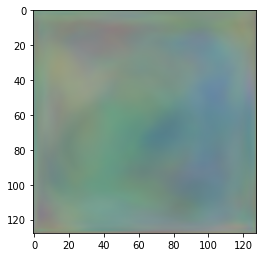

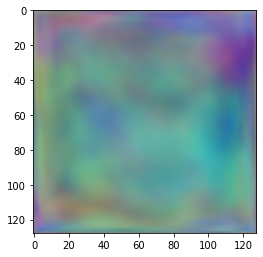

---------------------------------------------------------


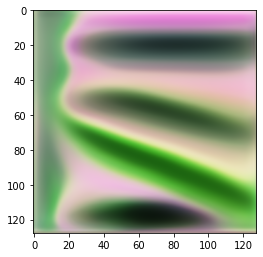

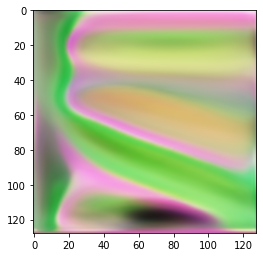

---------------------------------------------------------


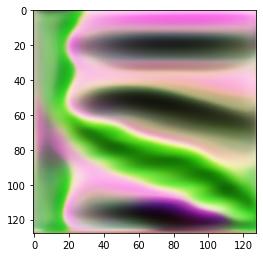

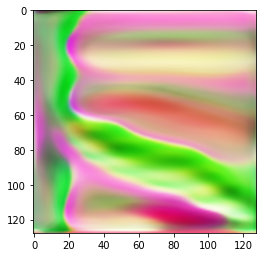

---------------------------------------------------------


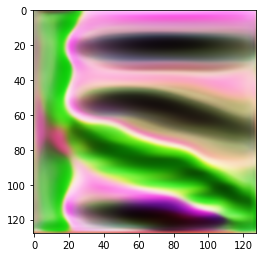

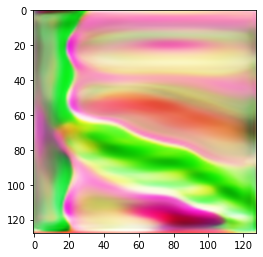

---------------------------------------------------------


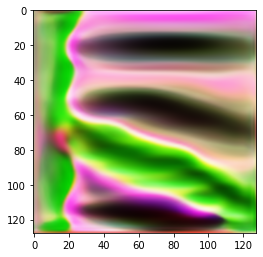

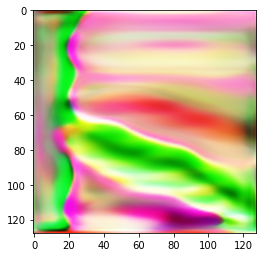

---------------------------------------------------------


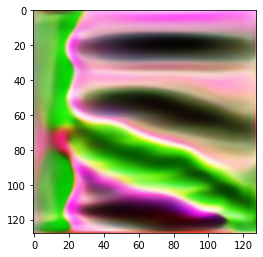

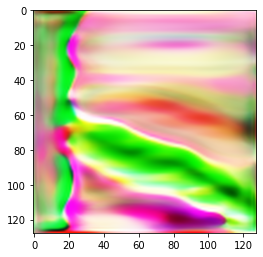

---------------------------------------------------------


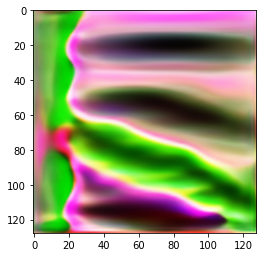

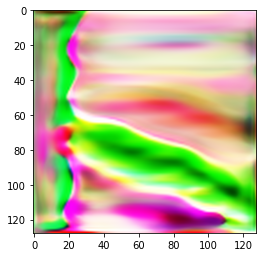

---------------------------------------------------------


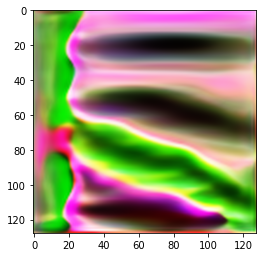

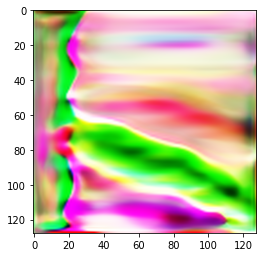

---------------------------------------------------------


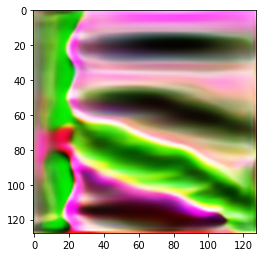

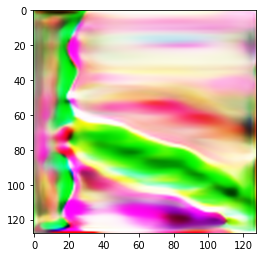

---------------------------------------------------------


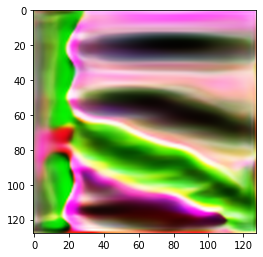

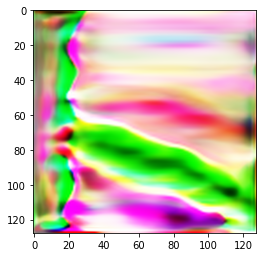

---------------------------------------------------------


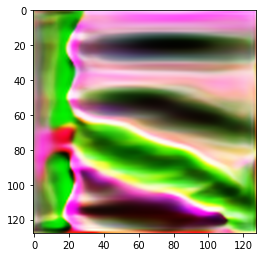

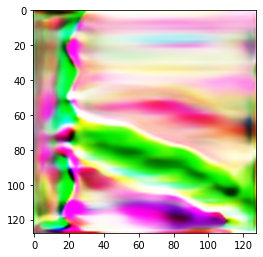

---------------------------------------------------------


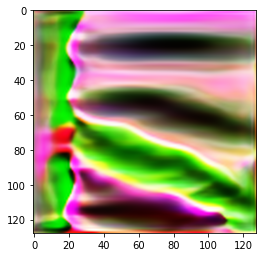

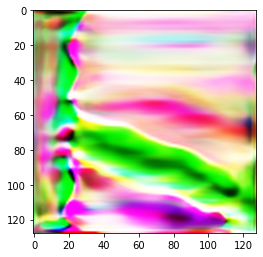

---------------------------------------------------------


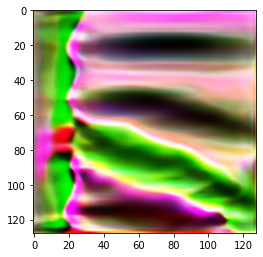

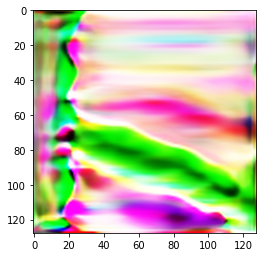

---------------------------------------------------------


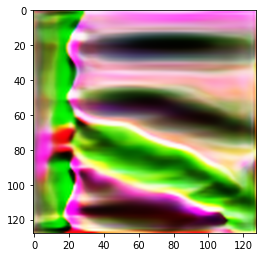

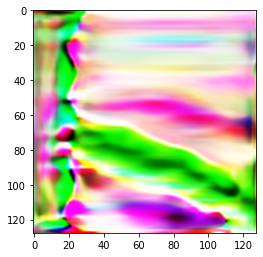

---------------------------------------------------------


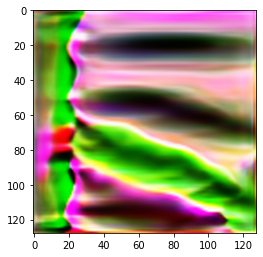

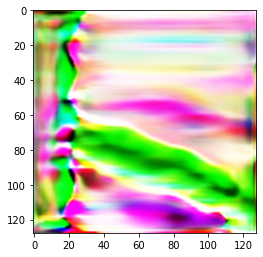

---------------------------------------------------------


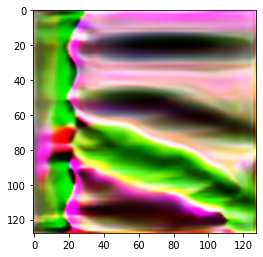

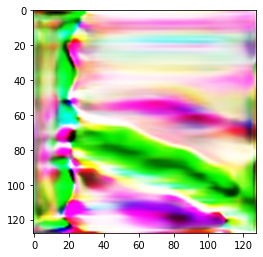

---------------------------------------------------------


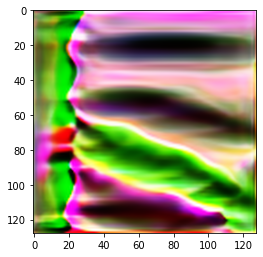

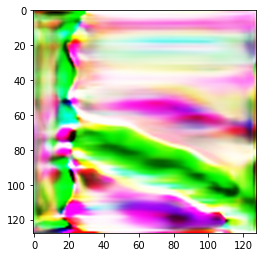

---------------------------------------------------------


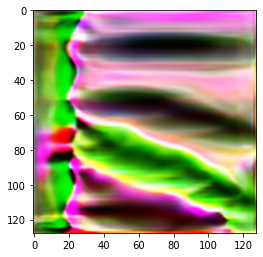

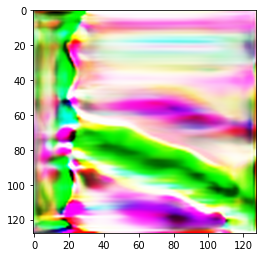

---------------------------------------------------------


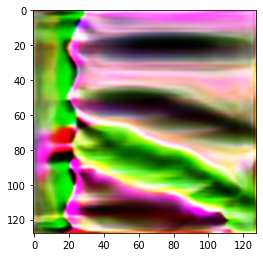

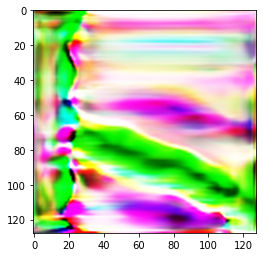

---------------------------------------------------------


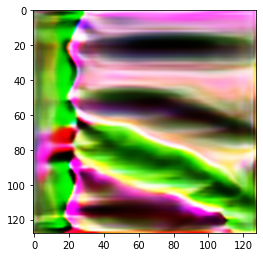

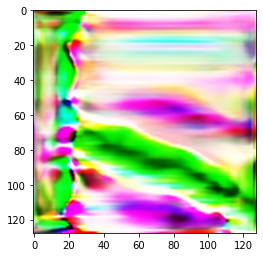

---------------------------------------------------------


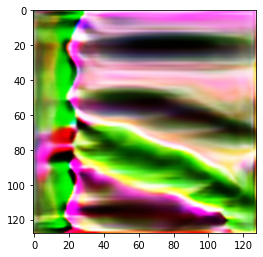

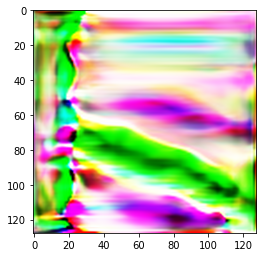

---------------------------------------------------------


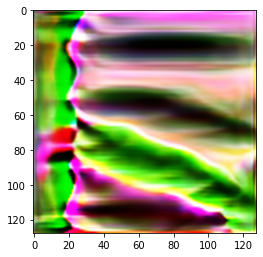

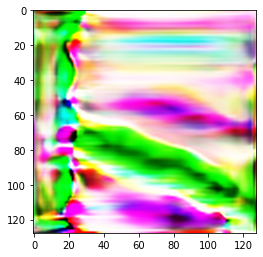

---------------------------------------------------------


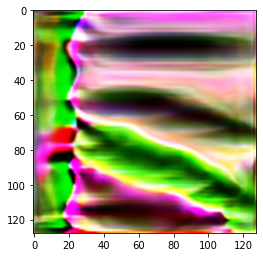

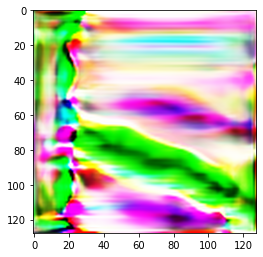

---------------------------------------------------------


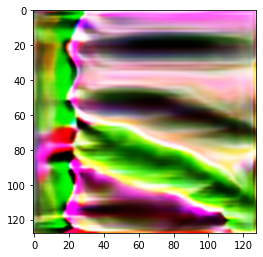

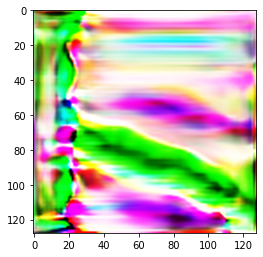

---------------------------------------------------------


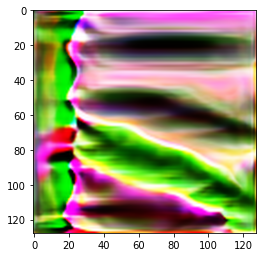

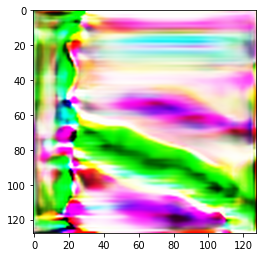

---------------------------------------------------------


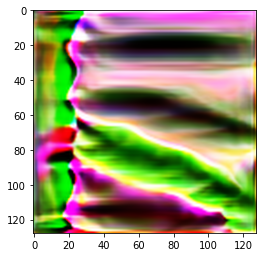

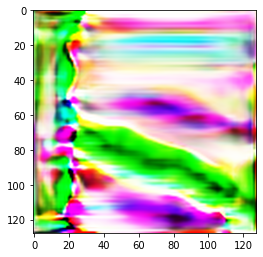

---------------------------------------------------------


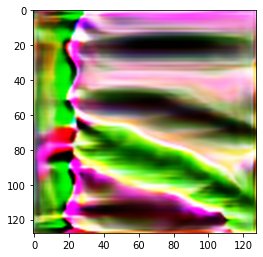

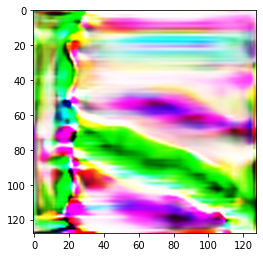

---------------------------------------------------------


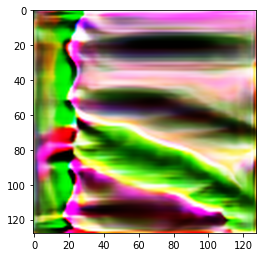

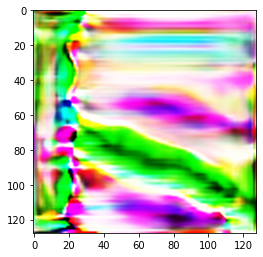

---------------------------------------------------------


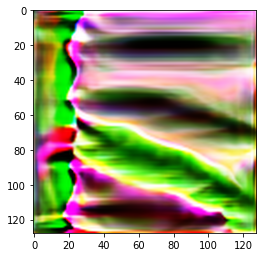

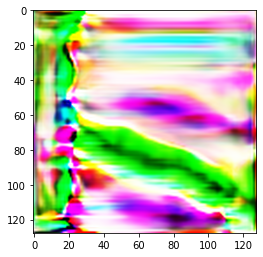

---------------------------------------------------------


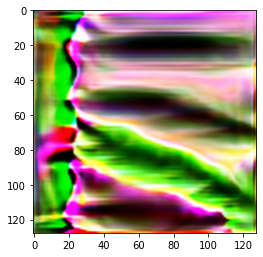

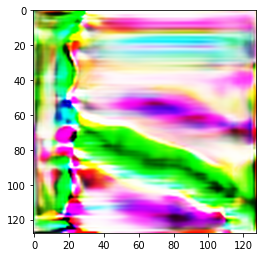

---------------------------------------------------------


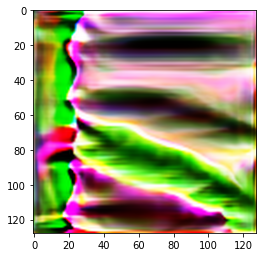

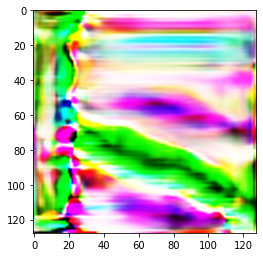

In [23]:
i=0

p = get_params(OPT_OVER, net, net_input)

optimize(OPTIMIZER, p, closure, LR, num_iter)

# Result

In [24]:
# Result
out = net(net_input)
    
fast_pathway = out[:,:,:32, :128, :128]
print(fast_pathway.shape)

video_to_save = fast_pathway

print(video_to_save.squeeze().shape)
video_to_save = video_to_save.squeeze().permute(1,2,3,0)
print(video_to_save.shape)

video_to_save_np = video_to_save.cpu().detach().numpy()
out_np1 = np.clip(video_to_save_np, 0, 1)

import skvideo.io
import numpy as np

outputdata = out_np1 * 255
outputdata = outputdata.astype(np.uint8)

torch.Size([1, 3, 32, 128, 128])
torch.Size([3, 32, 128, 128])
torch.Size([32, 128, 128, 3])


In [25]:
from cv2 import VideoWriter, VideoWriter_fourcc

width = 128
height = 128
FPS = 10
seconds = 3.2

fourcc = VideoWriter_fourcc(*'MP42')
video = VideoWriter('./am_'+str(map_idx).zfill(5) + "_" + layer_to_use+'.avi', fourcc, float(FPS), (width, height))

for i in range(32):
    frame = outputdata[i, :, :, :]
    video.write(frame)
video.release()